<a href="https://colab.research.google.com/github/kr-mohit/Lane-Detection-using-YOLOv3/blob/main/MLProject_(Mohit%2BNavneet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and Mounting

In [ ]:
# Mounting Drive 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [ ]:
import cv2
from google.colab.patches import cv2_imshow as ci #For using cv2.imshow
import numpy as np
import matplotlib.pyplot as plt

# Dataset Preparation

In [ ]:
vid = cv2.VideoCapture('/content/gdrive/My Drive/MLProject/lane2.mp4')

In [ ]:
k = 0
while k < 2100:
  ret, frame = vid.read()

  cv2.imwrite("frame%d.jpg" % k, frame)


  k = k + 1

vid.release()


In [ ]:
img = []

for i in range(0,2100):
  img.append(cv2.imread("frame%d.jpg" % i))

imgnp = np.array(img)

In [ ]:
print(imgnp.shape)

(5, 352, 640, 3)


In [ ]:
imgu = []

for i in range(0,2100):
  imgu.append(imgnp[i])

imgu = np.array(imgu)

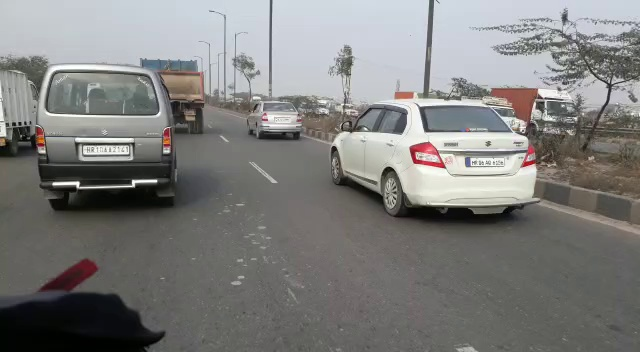

In [ ]:
ci(imgu[0])

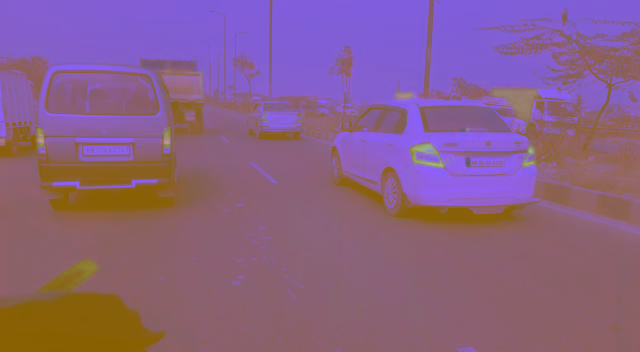

In [ ]:
luvl = [] #Array of frames in LUV colorspace
luvl_L = [] #Array of L,U,V channels for the individual frames
for i in range (0,2100):
  luv = cv2.cvtColor(imgnp[i], cv2.COLOR_BGR2LUV)
  luvl.append(luv)
  luvl_L.append(cv2.split(luv))
luvl = np.array(luvl)
ci(luvl[0])

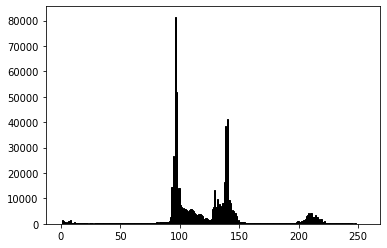

In [ ]:
plt.hist(luvl[0].ravel(), bins=256, range=(0.0, 256), fc='k', ec='k')
plt.show()


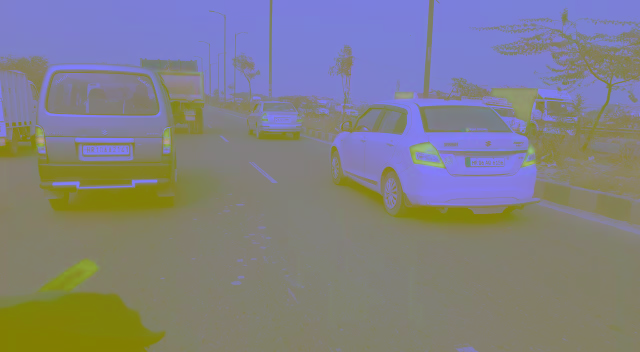

In [ ]:
labl = [] #Array of frames in LAB colorspace
labl_B = [] #Array of L,A,B channels for the individual frames
for i in range (0,2100):
  lab = cv2.cvtColor(imgnp[i], cv2.COLOR_BGR2LAB)
  labl.append(lab)
  labl_B.append(cv2.split(lab))
  # ci(hsv)
labl = np.array(labl)
ci(labl[0])

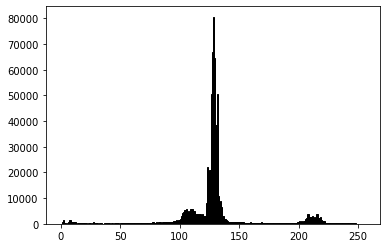

In [ ]:
plt.hist(labl[0].ravel(), bins=256, range=(0.0, 256), fc='k', ec='k')
plt.show()


In [ ]:
#Binary thresholding

thrl_w = [] #Array of thresholded frames for white lines

for i in range(0,len(imgu)):
  ret, thrw = cv2.threshold(luvl_L[i][0],150,255,cv2.THRESH_BINARY)
  thrl_w.append(thrw)

thrl_y = [] #Array of thresholded frames for yellow lines

for i in range(0,len(imgu)):
  ret, thry = cv2.threshold(labl_B[i][0],200,255,cv2.THRESH_BINARY)
  thrl_y.append(thry)

thrl_w = np.array(thrl_w)
thrl_y = np.array(thrl_y)

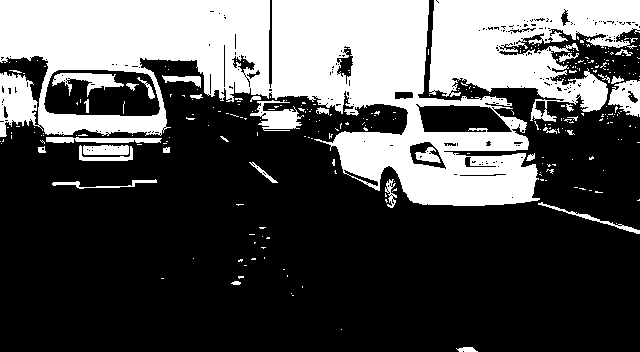

In [ ]:
#Threshold net output

out = []

for i in range(0,len(imgu)):
  out.append(np.bitwise_or(thrl_w[i],thrl_y[i]))

out = np.array(out)
ci(out[0])

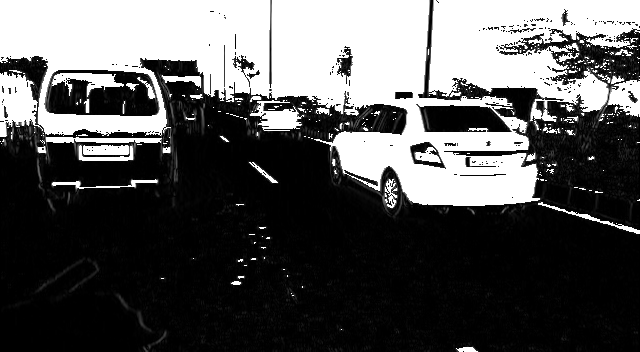

In [ ]:
#Gradient
grad = []

for i in range(0,len(imgu)):
  g = cv2.cvtColor(imgu[i], cv2.COLOR_BGR2GRAY)
  
  sobel = cv2.Sobel(g,cv2.CV_64F,1,0)
  
  abs_sobel = np.absolute(sobel)
  scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
  
  grad.append(np.bitwise_or(out[i],scaled_sobel))

ci(grad[0])

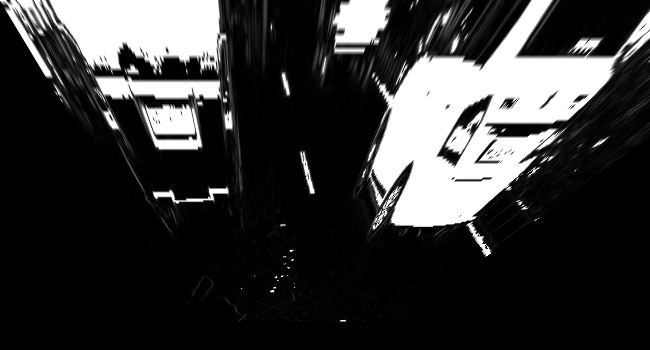

In [ ]:
#Taking bird view transform

img_ht = 350
img_wd = 650

init = np.float32([[0,img_ht], [650,img_ht], [0,0], [img_wd,0]])
fin = np.float32([[210,img_ht], [360, img_ht], [0,0], [img_wd+200, 0]])

#transformation matrices
tr_mat = cv2.getPerspectiveTransform(init, fin) #tranform
tr_mat_inv = cv2.getPerspectiveTransform(fin, init) #inverse transform

#Taking out ROI and warping

warpl = []

for i in range(0, len(imgu)):
  img = grad[i]
  img = img[120:(img_ht+100), 0:img_wd] #Cropping out ROI

  warp_img = cv2.warpPerspective(img, tr_mat, (img_wd, img_ht)) #Warping
  warpl.append(warp_img)

  # cv2.imwrite("/content/gdrive/My Drive/MLProject/transform-images2.0/threshold1-image-%d.jpg" % i, warp_img)

warpl = np.array(warpl)
ci(warpl[0])

In [ ]:
# clone darknet repo
import os

os.chdir("/content/gdrive/My Drive/MLProject/")

# !git clone https://github.com/AlexeyAB/darknet

# change makefile to have GPU and OPENCV enabled
import os
os.chdir("/content/gdrive/My Drive/MLProject/darknet/")
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile 

!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [ ]:
!chmod 755 /content/gdrive/My\ Drive/MLProject/darknet/darknet

%cd /content/gdrive/My\ Drive/MLProject/darknet

!./darknet detector train data/obj.data cfg/yolo-obj.cfg darknet53.conv.74 -dont_show

In [ ]:
!chmod 755 /content/gdrive/My\ Drive/MLProject/darknet/darknet

%cd /content/gdrive/My\ Drive/MLProject/darknet

!./darknet detector map data/obj.data cfg/yolo-obj.cfg backup/yolo-obj_final.weights -dont_show 

# Threshold Function

In [ ]:
def threshold(inp): 
    LUV = cv2.cvtColor(inp, cv2.COLOR_BGR2Luv)
    L,U,V=cv2.split(LUV)
    ret,imageL= cv2.threshold(L, 150,255,cv2.THRESH_BINARY)
   #cv2_imshow(imageL) 
  
  
    LAB=cv2.cvtColor(inp, cv2.COLOR_BGR2LAB)
    L,A,B=cv2.split(LAB)
    ret,imageB= cv2.threshold(B,200,255,cv2.THRESH_BINARY)
   #cv2_imshow(imageB)
  
    gray=cv2.cvtColor(inp,cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx= np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
  
    output = np.zeros(shape = imageL.shape)
    output = np.bitwise_or(imageL,imageB)


    return output
    

# img = cv2.imread('/content/gdrive/My Drive/p.jpg')

# img2 = threshold(img)
# ci(img2)

# Transform Function

In [ ]:
#Taking bird view transform
def  transform (image):
  img_ht = 350
  img_wd = 650

  init = np.float32([[0,img_ht], [650,img_ht], [0,0], [img_wd,0]])
  fin = np.float32([[210,img_ht], [360, img_ht], [0,0], [img_wd+200, 0]])

  #transformation matrices
  tr_mat = cv2.getPerspectiveTransform(init, fin) #tranform
  tr_mat_inv = np.linalg.inv(tr_mat) #inverse transform
  
  #Taking out ROI and warping

  # image = image[120:(img_ht+100), 0:img_wd] #Cropping out ROI
  warp_img = cv2.warpPerspective(image, tr_mat, (650, 350), cv2.INTER_LINEAR) #Warping

  return warp_img,tr_mat,tr_mat_inv


# Darknet.py

In [ ]:
import cv2
import numpy as np
#import matplotlib.pyplot as plt
import os
from ctypes import *
import math
import random
import time
import re 

def sample(probs):
    s = sum(probs)
    probs = [a/s for a in probs]
    r = random.uniform(0, 1)
    for i in range(len(probs)):
        r = r - probs[i]
        if r <= 0:
            return i
    return len(probs)-1

def c_array(ctype, values):
    arr = (ctype*len(values))()
    arr[:] = values
    return arr

class BOX(Structure):
    _fields_ = [("x", c_float),
                ("y", c_float),
                ("w", c_float),
                ("h", c_float)]

class DETECTION(Structure):
    _fields_ = [("bbox", BOX),
                ("classes", c_int),
                ("prob", POINTER(c_float)),
                ("mask", POINTER(c_float)),
                ("objectness", c_float),
                ("sort_class", c_int),
                ("uc", POINTER(c_float)),
                ("points", c_int),
                ("embeddings", POINTER(c_float)),
                ("embedding_size", c_int),
                ("sim", c_float),
                ("track_id", c_int)]

class DETNUMPAIR(Structure):
    _fields_ = [("num", c_int),
                ("dets", POINTER(DETECTION))]

class IMAGE(Structure):
    _fields_ = [("w", c_int),
                ("h", c_int),
                ("c", c_int),
                ("data", POINTER(c_float))]

class METADATA(Structure):
    _fields_ = [("classes", c_int),
                ("names", POINTER(c_char_p))]



#lib = CDLL("/home/pjreddie/documents/darknet/libdarknet.so", RTLD_GLOBAL)
#lib = CDLL("libdarknet.so", RTLD_GLOBAL)
hasGPU = True
if os.name == "nt":
    cwd = os.path.dirname(__file__)
    os.environ['PATH'] = cwd + ';' + os.environ['PATH']
    winGPUdll = os.path.join(cwd, "yolo_cpp_dll.dll")
    winNoGPUdll = os.path.join(cwd, "yolo_cpp_dll_nogpu.dll")
    envKeys = list()
    for k, v in os.environ.items():
        envKeys.append(k)
    try:
        try:
            tmp = os.environ["FORCE_CPU"].lower()
            if tmp in ["1", "true", "yes", "on"]:
                raise ValueError("ForceCPU")
            else:
                print("Flag value '"+tmp+"' not forcing CPU mode")
        except KeyError:
            # We never set the flag
            if 'CUDA_VISIBLE_DEVICES' in envKeys:
                if int(os.environ['CUDA_VISIBLE_DEVICES']) < 0:
                    raise ValueError("ForceCPU")
            try:
                global DARKNET_FORCE_CPU
                if DARKNET_FORCE_CPU:
                    raise ValueError("ForceCPU")
            except NameError:
                pass
            # print(os.environ.keys())
            # print("FORCE_CPU flag undefined, proceeding with GPU")
        if not os.path.exists(winGPUdll):
            raise ValueError("NoDLL")
        lib = CDLL(winGPUdll, RTLD_GLOBAL)
    except (KeyError, ValueError):
        hasGPU = False
        if os.path.exists(winNoGPUdll):
            lib = CDLL(winNoGPUdll, RTLD_GLOBAL)
            print("Notice: CPU-only mode")
        else:
            # Try the other way, in case no_gpu was
            # compile but not renamed
            lib = CDLL(winGPUdll, RTLD_GLOBAL)
            print("Environment variables indicated a CPU run, but we didn't find `"+winNoGPUdll+"`. Trying a GPU run anyway.")
else:
    lib = CDLL("./libdarknet.so", RTLD_GLOBAL)
lib.network_width.argtypes = [c_void_p]
lib.network_width.restype = c_int
lib.network_height.argtypes = [c_void_p]
lib.network_height.restype = c_int

copy_image_from_bytes = lib.copy_image_from_bytes
copy_image_from_bytes.argtypes = [IMAGE,c_char_p]

def network_width(net):
    return lib.network_width(net)

def network_height(net):
    return lib.network_height(net)

predict = lib.network_predict_ptr
predict.argtypes = [c_void_p, POINTER(c_float)]
predict.restype = POINTER(c_float)

if hasGPU:
    set_gpu = lib.cuda_set_device
    set_gpu.argtypes = [c_int]

init_cpu = lib.init_cpu

make_image = lib.make_image
make_image.argtypes = [c_int, c_int, c_int]
make_image.restype = IMAGE

get_network_boxes = lib.get_network_boxes
get_network_boxes.argtypes = [c_void_p, c_int, c_int, c_float, c_float, POINTER(c_int), c_int, POINTER(c_int), c_int]
get_network_boxes.restype = POINTER(DETECTION)

make_network_boxes = lib.make_network_boxes
make_network_boxes.argtypes = [c_void_p]
make_network_boxes.restype = POINTER(DETECTION)

free_detections = lib.free_detections
free_detections.argtypes = [POINTER(DETECTION), c_int]

free_batch_detections = lib.free_batch_detections
free_batch_detections.argtypes = [POINTER(DETNUMPAIR), c_int]

free_ptrs = lib.free_ptrs
free_ptrs.argtypes = [POINTER(c_void_p), c_int]

network_predict = lib.network_predict_ptr
network_predict.argtypes = [c_void_p, POINTER(c_float)]

reset_rnn = lib.reset_rnn
reset_rnn.argtypes = [c_void_p]

load_net = lib.load_network
load_net.argtypes = [c_char_p, c_char_p, c_int]
load_net.restype = c_void_p

load_net_custom = lib.load_network_custom
load_net_custom.argtypes = [c_char_p, c_char_p, c_int, c_int]
load_net_custom.restype = c_void_p

do_nms_obj = lib.do_nms_obj
do_nms_obj.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

do_nms_sort = lib.do_nms_sort
do_nms_sort.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

free_image = lib.free_image
free_image.argtypes = [IMAGE]

letterbox_image = lib.letterbox_image
letterbox_image.argtypes = [IMAGE, c_int, c_int]
letterbox_image.restype = IMAGE

load_meta = lib.get_metadata
lib.get_metadata.argtypes = [c_char_p]
lib.get_metadata.restype = METADATA

load_image = lib.load_image_color
load_image.argtypes = [c_char_p, c_int, c_int]
load_image.restype = IMAGE

rgbgr_image = lib.rgbgr_image
rgbgr_image.argtypes = [IMAGE]

predict_image = lib.network_predict_image
predict_image.argtypes = [c_void_p, IMAGE]
predict_image.restype = POINTER(c_float)

predict_image_letterbox = lib.network_predict_image_letterbox
predict_image_letterbox.argtypes = [c_void_p, IMAGE]
predict_image_letterbox.restype = POINTER(c_float)

network_predict_batch = lib.network_predict_batch
network_predict_batch.argtypes = [c_void_p, IMAGE, c_int, c_int, c_int,
                                   c_float, c_float, POINTER(c_int), c_int, c_int]
network_predict_batch.restype = POINTER(DETNUMPAIR)

def array_to_image(arr):
    import numpy as np
    # need to return old values to avoid python freeing memory
    arr = arr.transpose(2,0,1)
    c = arr.shape[0]
    h = arr.shape[1]
    w = arr.shape[2]
    arr = np.ascontiguousarray(arr.flat, dtype=np.float32) / 255.0
    data = arr.ctypes.data_as(POINTER(c_float))
    im = IMAGE(w,h,c,data)
    return im, arr

def classify(net, meta, im):
    out = predict_image(net, im)
    res = []
    for i in range(meta.classes):
        if altNames is None:
            nameTag = meta.names[i]
        else:
            nameTag = altNames[i]
        res.append((nameTag, out[i]))
    res = sorted(res, key=lambda x: -x[1])
    return res

def detect(net, meta, image, thresh=.5, hier_thresh=.5, nms=.45, debug= False):
    """
    Performs the meat of the detection
    """
    #pylint: disable= C0321
    im = load_image(image, 0, 0)
    if debug: print("Loaded image")
    ret = detect_image(net, meta, im, thresh, hier_thresh, nms, debug)
    free_image(im)
    if debug: print("freed image")
    return ret

def detect_image(net, meta, im, thresh=.5, hier_thresh=.5, nms=.45, debug= False):
    #import cv2
    #custom_image_bgr = cv2.imread(image) # use: detect(,,imagePath,)
    #custom_image = cv2.cvtColor(custom_image_bgr, cv2.COLOR_BGR2RGB)
    #custom_image = cv2.resize(custom_image,(lib.network_width(net), lib.network_height(net)), interpolation = cv2.INTER_LINEAR)
    #import scipy.misc
    #custom_image = scipy.misc.imread(image)
    #im, arr = array_to_image(custom_image)		# you should comment line below: free_image(im)
    num = c_int(0)
    if debug: print("Assigned num")
    pnum = pointer(num)
    if debug: print("Assigned pnum")
    predict_image(net, im)
    letter_box = 0
    #predict_image_letterbox(net, im)
    #letter_box = 1
    if debug: print("did prediction")
    #dets = get_network_boxes(net, custom_image_bgr.shape[1], custom_image_bgr.shape[0], thresh, hier_thresh, None, 0, pnum, letter_box) # OpenCV
    dets = get_network_boxes(net, im.w, im.h, thresh, hier_thresh, None, 0, pnum, letter_box)
    if debug: print("Got dets")
    num = pnum[0]
    if debug: print("got zeroth index of pnum")
    if nms:
        do_nms_sort(dets, num, meta.classes, nms)
    if debug: print("did sort")
    res = []
    if debug: print("about to range")
    for j in range(num):
        if debug: print("Ranging on "+str(j)+" of "+str(num))
        if debug: print("Classes: "+str(meta), meta.classes, meta.names)
        for i in range(meta.classes):
            if debug: print("Class-ranging on "+str(i)+" of "+str(meta.classes)+"= "+str(dets[j].prob[i]))
            if dets[j].prob[i] > 0:
                b = dets[j].bbox
                if altNames is None:
                    nameTag = meta.names[i]
                else:
                    nameTag = altNames[i]
                if debug:
                    print("Got bbox", b)
                    print(nameTag)
                    print(dets[j].prob[i])
                    print((b.x, b.y, b.w, b.h))
                res.append((nameTag, dets[j].prob[i], (b.x, b.y, b.w, b.h)))
    if debug: print("did range")
    res = sorted(res, key=lambda x: -x[1])
    if debug: print("did sort")
    free_detections(dets, num)
    if debug: print("freed detections")
    return res





def performDetect(imagePath="data/dog.jpg", thresh= 0.15, configPath = "./cfg/yolov4.cfg", weightPath = "yolov4.weights", metaPath= "./cfg/coco.data", showImage= True, makeImageOnly = False, initOnly= False):
    
    # Import the global variables. This lets us instance Darknet once, then just call performDetect() again without instancing again
    global metaMain, netMain, altNames #pylint: disable=W0603
    assert 0 < thresh < 1, "Threshold should be a float between zero and one (non-inclusive)"
    if not os.path.exists(configPath):
        raise ValueError("Invalid config path `"+os.path.abspath(configPath)+"`")
    if not os.path.exists(weightPath):
        raise ValueError("Invalid weight path `"+os.path.abspath(weightPath)+"`")
    if not os.path.exists(metaPath):
        raise ValueError("Invalid data file path `"+os.path.abspath(metaPath)+"`")
    if netMain is None:
        netMain = load_net_custom(configPath.encode("ascii"), weightPath.encode("ascii"), 0, 1)  # batch size = 1
        print("kkk")
    if metaMain is None:
        metaMain = load_meta(metaPath.encode("ascii"))
    if altNames is None:
        # In Python 3, the metafile default access craps out on Windows (but not Linux)
        # Read the names file and create a list to feed to detect
        try:
            with open(metaPath) as metaFH:
                metaContents = metaFH.read()
                
                match = re.search("names *= *(.*)$", metaContents, re.IGNORECASE | re.MULTILINE)
                if match:
                    result = match.group(1)
                else:
                    result = None
                try:
                    if os.path.exists(result):
                        with open(result) as namesFH:
                            namesList = namesFH.read().strip().split("\n")
                            altNames = [x.strip() for x in namesList]
                except TypeError:
                    pass
        except Exception:
            pass
    if initOnly:
        print("Initialized detector")
        return None
    if not os.path.exists(imagePath):
        raise ValueError("Invalid image path `"+os.path.abspath(imagePath)+"`")
    # Do the detection
    #detections = detect(netMain, metaMain, imagePath, thresh)  # if is used cv2.imread(image)
    detections = detect(netMain, metaMain, imagePath.encode("ascii"), thresh)
    detections = {
                "detections": detections,
                }
    return detections
 
 

# Main

kkk
{'detections': [('line', 0.8889865875244141, (283.6710510253906, 295.5944519042969, 9.34859848022461, 10.807759284973145)), ('line', 0.6414044499397278, (269.5455627441406, 274.7032775878906, 5.472951412200928, 6.408613204956055)), ('line', 0.3838413655757904, (391.2259216308594, 315.53826904296875, 20.174131393432617, 14.867585182189941)), ('line', 0.3238806128501892, (320.2785949707031, 348.6156311035156, 11.11871337890625, 3.066248893737793)), ('line', 0.1979813277721405, (313.7197570800781, 277.2160949707031, 6.523816108703613, 9.09671688079834)), ('line', 0.15626834332942963, (271.1789855957031, 276.6939697265625, 4.837851047515869, 5.523269176483154))]}
frame #1
6


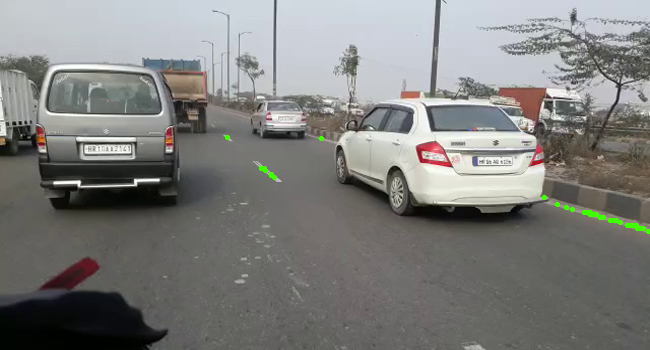

{'detections': [('line', 0.951316237449646, (284.5059814453125, 298.01263427734375, 9.677508354187012, 10.504770278930664)), ('line', 0.678747296333313, (390.22637939453125, 315.1432189941406, 19.569778442382812, 14.212327003479004)), ('line', 0.633118212223053, (271.37603759765625, 276.896240234375, 4.756374359130859, 6.240035533905029)), ('line', 0.4325714111328125, (313.00830078125, 277.23565673828125, 6.939193248748779, 9.026047706604004)), ('line', 0.3369274139404297, (270.2023010253906, 275.40692138671875, 4.621246337890625, 6.2676544189453125))]}
frame #2
5


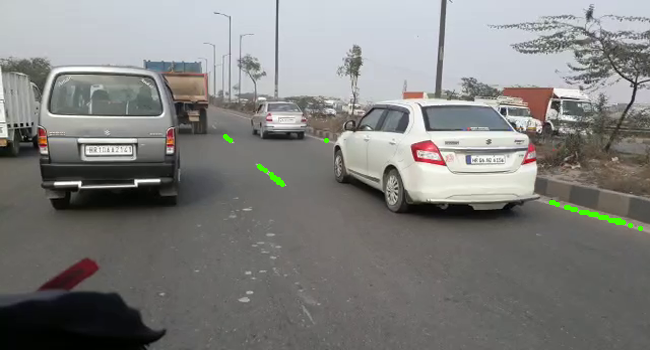

{'detections': [('line', 0.6552519202232361, (283.26959228515625, 298.5776672363281, 9.623022079467773, 13.02957820892334)), ('line', 0.5381916165351868, (268.0428466796875, 275.6275329589844, 4.83632755279541, 5.337735652923584)), ('line', 0.5136387348175049, (269.2795104980469, 276.7574462890625, 5.046834468841553, 6.296370029449463)), ('line', 0.46521371603012085, (310.3586120605469, 275.45367431640625, 7.014418125152588, 6.961433410644531)), ('line', 0.3828960359096527, (388.873046875, 316.1519775390625, 29.133583068847656, 14.146624565124512))]}
frame #3
5


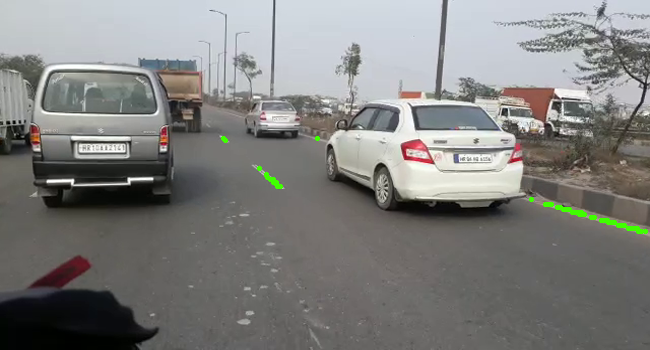

{'detections': [('line', 0.7800359129905701, (266.749267578125, 275.4152526855469, 4.8370161056518555, 5.4651947021484375)), ('line', 0.5392487645149231, (387.4170837402344, 315.5949401855469, 34.955963134765625, 18.47762107849121)), ('line', 0.39916566014289856, (283.4165954589844, 299.8528747558594, 11.052663803100586, 13.936386108398438)), ('line', 0.22416061162948608, (309.9395751953125, 274.4259948730469, 9.241912841796875, 7.4165120124816895))]}
frame #4
4


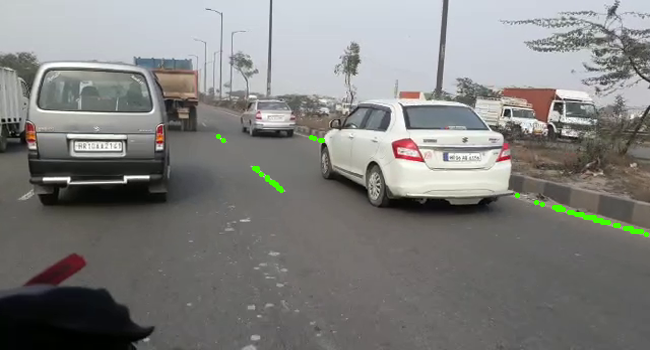

{'detections': [('line', 0.8755679130554199, (283.1183166503906, 300.88348388671875, 11.491547584533691, 14.837206840515137)), ('line', 0.7075296640396118, (266.2906799316406, 277.0245361328125, 4.9046735763549805, 6.2400312423706055)), ('line', 0.45499858260154724, (381.9023742675781, 315.1721496582031, 35.92705154418945, 19.51105499267578)), ('line', 0.39949163794517517, (191.62612915039062, 309.2858581542969, 6.532232761383057, 8.724794387817383)), ('line', 0.2690727114677429, (305.92059326171875, 274.5328063964844, 6.195066452026367, 6.020884990692139))]}
frame #5
5


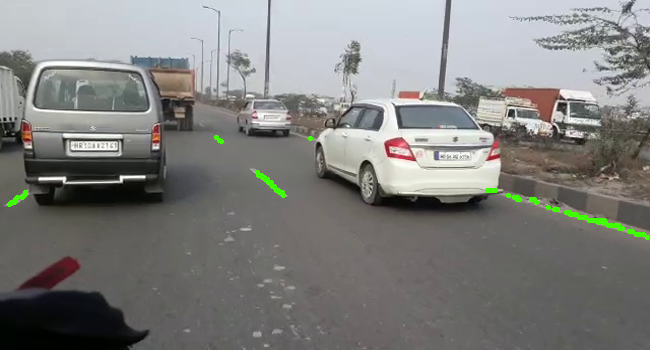

{'detections': [('line', 0.725468635559082, (191.55418395996094, 310.5215148925781, 6.994962692260742, 9.321474075317383)), ('line', 0.7009812593460083, (266.0611877441406, 278.82708740234375, 4.812249660491943, 5.881698131561279)), ('line', 0.6111713647842407, (283.5555419921875, 303.49041748046875, 11.772987365722656, 14.893879890441895)), ('line', 0.6033694744110107, (381.3495178222656, 315.2899475097656, 37.24348449707031, 15.460734367370605)), ('line', 0.12874747812747955, (305.6112060546875, 277.4185791015625, 4.285062789916992, 7.639354705810547))]}
frame #6
5


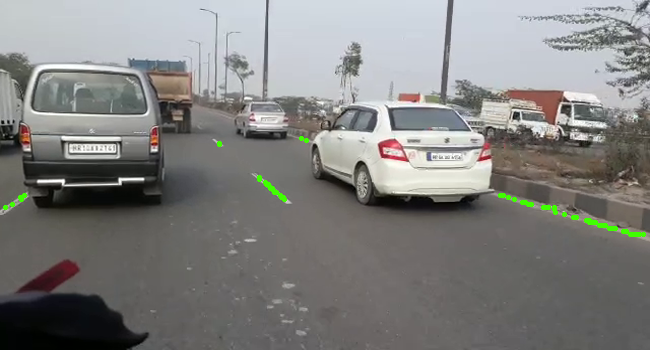

{'detections': [('line', 0.9745252132415771, (285.02679443359375, 305.7431335449219, 12.260659217834473, 15.1602201461792)), ('line', 0.7986985445022583, (191.98861694335938, 310.8577880859375, 6.655824661254883, 10.439539909362793)), ('line', 0.7426815629005432, (266.3518371582031, 279.8199768066406, 5.009735107421875, 5.6320013999938965)), ('line', 0.1984148472547531, (304.8352355957031, 277.204345703125, 4.541799545288086, 8.024270057678223)), ('line', 0.15886105597019196, (380.1586608886719, 314.7718200683594, 31.11931610107422, 18.585779190063477))]}
frame #7
5


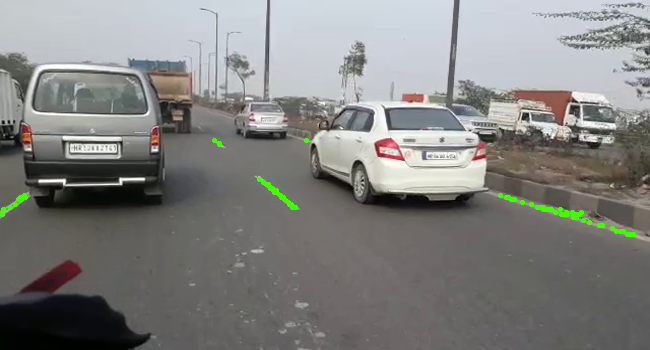

{'detections': [('line', 0.9503266215324402, (287.80108642578125, 307.8529052734375, 12.778562545776367, 15.838288307189941)), ('line', 0.8687143921852112, (193.57867431640625, 311.95599365234375, 8.421927452087402, 11.896000862121582)), ('line', 0.684107780456543, (268.2318115234375, 281.5612487792969, 4.994421482086182, 6.344226837158203)), ('line', 0.3949078321456909, (380.04022216796875, 314.4414978027344, 33.29655456542969, 19.729673385620117)), ('line', 0.10839098691940308, (304.07452392578125, 275.17840576171875, 6.102649211883545, 7.691781997680664))]}
frame #8
5


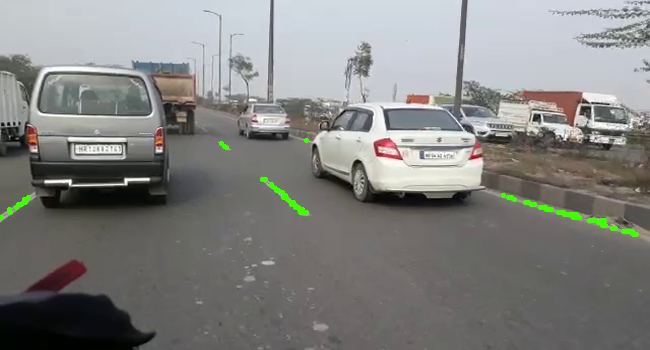

{'detections': [('line', 0.9062715768814087, (289.7265319824219, 309.4021301269531, 11.8433198928833, 16.321334838867188)), ('line', 0.8574716448783875, (193.71018981933594, 311.0813293457031, 8.379642486572266, 11.80855655670166)), ('line', 0.8310152292251587, (268.553955078125, 279.9420166015625, 4.976607799530029, 6.912978649139404)), ('line', 0.1196896955370903, (379.94390869140625, 311.7619323730469, 35.55192565917969, 20.676986694335938))]}
frame #9
4


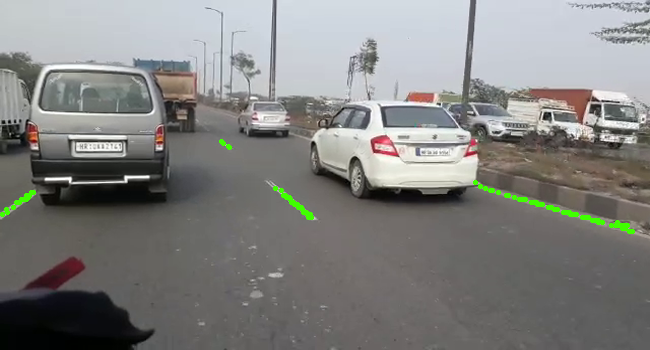

{'detections': [('line', 0.9158589839935303, (291.3580017089844, 310.8091735839844, 14.166773796081543, 18.408857345581055)), ('line', 0.8990539908409119, (193.3911895751953, 310.6202392578125, 9.31667423248291, 11.426520347595215)), ('line', 0.8826671838760376, (268.31201171875, 280.07330322265625, 5.26253080368042, 6.506250381469727)), ('line', 0.22858837246894836, (305.4882507324219, 273.8612365722656, 4.818125247955322, 6.016730785369873)), ('line', 0.19096003472805023, (379.5333251953125, 311.2749328613281, 30.90401840209961, 24.97828483581543))]}
frame #10
5


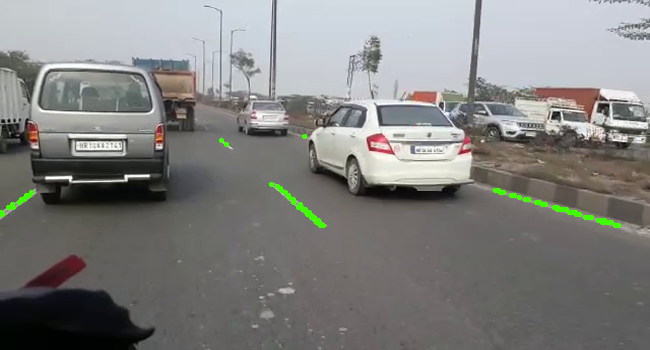

In [ ]:
netMain = None
metaMain = None
altNames = None 


video= cv2.VideoCapture('/content/gdrive/MyDrive/MLProject/lane2.mp4')
success,vid_frame = video.read()

i = 0
iterations = 10               # change to number of frames you want
while (success and i < iterations):             


  resize_img = cv2.resize(vid_frame, dsize=(650, 350), interpolation=cv2.INTER_CUBIC)

  threshold_img = threshold (resize_img)

  transformed_img,tr_matrix,tr_mat_inv = transform (threshold_img)                           #this will return transformed image, followed by m followed by m_inv
  
  cv2.imwrite ("/content/gdrive/MyDrive/MLProject/MLimages/frame%d.jpg" %i, transformed_img)


  D = performDetect(imagePath= "/content/gdrive/MyDrive/MLProject/MLimages/frame%d.jpg" %i, thresh = 0.10, configPath = "/content/gdrive/MyDrive/MLProject/darknet/cfg/yolo-obj.cfg", weightPath = "/content/gdrive/MyDrive/MLProject/darknet/backup/yolo-obj_final.weights", metaPath= "/content/gdrive/MyDrive/MLProject/darknet/data/obj.data")
  print(D)

  print ("frame ",i+1,sep='#')
 
  #counting number of boxes
  count = 0
  for j in D['detections']:
    count = count + 1

  print(count)
  target_image = resize_img
  okimg=transformed_img


  #marking lanes in original frame

  height, width = okimg.shape[0], okimg.shape[1]
  for k in range(count):                              #count contains the number of boxes in the frame
    for a in range(max(0, int(D['detections'][k][2][1] - (D['detections'][k][2][3]) / 2)), min(height, int(D['detections'][k][2][1] + (D['detections'][k][2][3]) /2))):
      for b in range(max(0, int(D['detections'][k][2][0] - (D['detections'][k][2][2]) / 2)), min(width, int(D['detections'][k][2][0] + (D['detections'][k][2][2]) /2))):
        if okimg[a, b] == 255 :
          n = tr_mat_inv.dot(np.array([[b], [a],[1]]));
          p = int(n[0][0] / n[2][0])
          q = int(n[1][0] / n[2][0])
          # target_image[q, p] = (0,0,255) 
          cv2.circle(target_image,(p,q),1,(0,255,64),2)
          
  ci(target_image)
  cv2.imwrite ("/content/gdrive/MyDrive/MLProject/MarkedImages/final_frame%d.jpg" %i,target_image)
  success,vid_frame = video.read()
  i=i+1





In [ ]:
import glob

frameSize = (650, 350)

out = cv2.VideoWriter('/content/gdrive/MyDrive/MLProject/output_video_002.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, frameSize)

import os
path='/content/gdrive/MyDrive/MLProject/MarkedImages'
file=os.listdir(path)
for i in file:
    print("hey")
    img = cv2.imread('/content/gdrive/MyDrive/MLProject/MarkedImages/'+i)
    # ci(img)
    out.write(img)

out.release()